In [12]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from rich.jupyter import print as rprint
from torchvision.datasets import ImageFolder
from rich.progress import Progress, SpinnerColumn, TextColumn, TaskProgressColumn, TimeRemainingColumn, BarColumn, ProgressColumn, MofNCompleteColumn

# custom imports
from mobilevit import MobileViT

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# progress printing helpers
class TaskIterationsPerSecondColumn(ProgressColumn):

    def __init__(self, emoji: str, color: str, unit: str):
        super(TaskIterationsPerSecondColumn, self).__init__()
        self.emoji = emoji
        self.color = color
        self.unit = unit


    def render(self, task):
        return f"{self.emoji} [{self.color}]{(task.speed or 0):>02.01f} {self.unit}"

In [9]:
# load image dataset

# hyperparameters
image_dim = (256, 256)
batch_size = 32
epochs = 100
early_stopping = 9
model_checkpoint = 'mobilevit_s_birds400.pth'

# trainset transforms
train_transforms = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# note: horizontal flip applied during training only
# validset/testset transforms
valid_transforms = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.ToTensor(),
])

# generate train and valid datasets
train_dir = "birds-400/train"
valid_dir = "birds-400/valid"
test_dir = "birds-400/test"

train_dataset = ImageFolder(train_dir, train_transforms)
valid_dataset = ImageFolder(valid_dir, valid_transforms)
test_dataset = ImageFolder(test_dir, valid_transforms)

# generate train and valid dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# store idx2class
idx2class = {v: k for k,v in train_dataset.class_to_idx.items()}

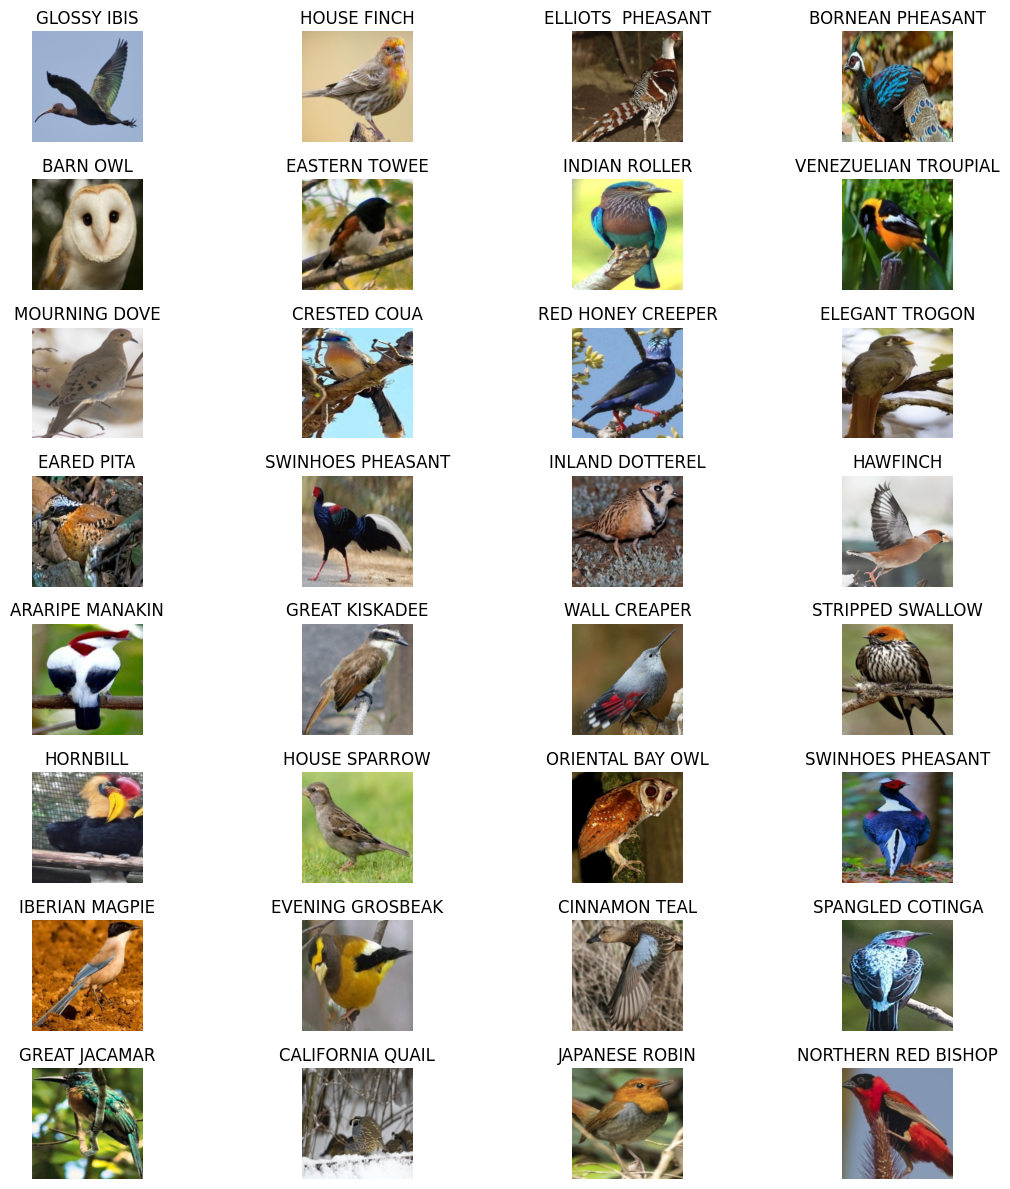

In [4]:
# plot a batch
def print_grid(images: torch.tensor, labels: torch.tensor):
    # gather idx2class mapping
    idx2class = {v: k for k,v in train_dataset.class_to_idx.items()}
    
    # determine batch size
    batch_size = len(images)
    
    # determine number of image rows
    n_cols = 4
    n_rows = batch_size // 4
    if batch_size % 4 != 0:
    	n_rows += 1
    
    # create figure object to hold the grid
    fig = plt.figure(figsize=(12, 12))
    
    # plot images with labels
    ax = list()
    for inx in range(batch_size):
        # gather image + label
        image, label = images[inx], labels[inx]
        
        # convert image and label to numpy
        image = image.numpy()
        label = idx2class[label.numpy().tolist()]
        
        # transpose image to properly convert to numpy format
        # since torch uses (channel, height, width) compared to 
        # (height, width, channels) of OpenCV/numpy
        image = np.transpose(image, (1, 2, 0))
        
        # append subplot
        ax.append(fig.add_subplot(n_rows, n_cols, inx+1))
        
        # append label to subplot
        ax[-1].set_title(label)
        
        # switch of axes
        ax[-1].axis('off')
        
        # display image
        plt.imshow(image)
    
    # ensure correct padding between subplots
    fig.tight_layout()
    
    # display full grid
    plt.savefig('sample.png')
    plt.show()

    
# gather one iteration of data from dataloader
iter_data = iter(train_dataloader)
images, labels = iter_data.next()
print_grid(images=images, labels=labels)

In [5]:
# define model - MobileViT 'S' architecture
dims = [144, 192, 240]
channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
model = MobileViT(image_dim, dims, channels, num_classes=len(train_dataset.classes))

In [6]:
# define loss function
criterion = torch.nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# determine training device
training_device = "cuda" if torch.cuda.is_available() else "cpu"
rprint(f"[magenta3][b]Training Device:[/b] {training_device}")

# move model to the correct device
model.to(training_device)

# start model training
no_improvement_epochs = 0
prev_validation_loss = np.inf
with Progress(
            TextColumn("[progress.description]{task.description}"),
            SpinnerColumn(spinner_name="dots"),
            BarColumn(bar_width=None),
            TaskProgressColumn(show_speed=True),
            TimeRemainingColumn(elapsed_when_finished=True),
            TextColumn("[yellow]{task.completed}/{task.total}"),
            TaskIterationsPerSecondColumn(emoji=":earth_asia:", color="indian_red", unit="It/s"),
            expand=True,
    ) as progress:
    # create epoch task
    epoch_task = progress.add_task(description='[bold green_yellow]Epoch Progress', total=epochs)
    
    # loop over the dataset multiple times
    total_batches = len(train_dataloader)
    for epoch in range(epochs):
        # create batch task
        batch_task = progress.add_task(description='[gold1]Batch Progress', total=total_batches)
        
        # run training
        running_loss = 0.0
        for data in train_dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(training_device), labels.to(training_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # gather running loss
            running_loss += loss.item()
            
            # update progress bar
            progress.update(task_id=batch_task, advance=1)
        
        # remove batch progress bar
        progress.remove_task(task_id=batch_task)
        
        # put model to evaluation mode for validation testing
        model.eval()

        # run validation
        with torch.no_grad():
            validation_loss = 0.0
            for data in valid_dataloader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(training_device), labels.to(training_device)

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # gather validation loss
                validation_loss += loss.item()

        # save checkpoint, if better than prev. validation loss
        if validation_loss <= prev_validation_loss:
            # set validation loss
            prev_validation_loss = validation_loss

            # save model checkpoint
            torch.save(model.state_dict(), model_checkpoint)

            # reset early stopping counter
            no_improvement_epochs = 0
            
        else:
            # increment early stopping counter
            no_improvement_epochs += 1
        
        # print statistics at end of training epoch
        print(f'[EPOCH: {epoch + 1:>3d}] loss: {running_loss / len(train_dataloader):>01.09f}  {"🏆" if not no_improvement_epochs else ""}')
        
        # update progress bar
        progress.update(task_id=epoch_task, advance=1)

        # early stopping check
        if no_improvement_epochs >= early_stopping:
            break

        # put model back to training mode for further training
        model.train()

# save the weights of the last epoch
last_model_checkpoint = model_checkpoint.split('.')
last_model_checkpoint = "".join(last_model_checkpoint[:-1]+['_last','.']+last_model_checkpoint[-1:])
torch.save(model.state_dict(), last_model_checkpoint)

print()
rprint(f'[bold chartreuse3]Finished Training, after {epoch+1} Epochs.')

Training Device: cuda

Output()

[EPOCH:   1] loss: 5.422109194  🏆

[EPOCH:   2] loss: 4.404471416  🏆

[EPOCH:   3] loss: 3.694053556  🏆

[EPOCH:   4] loss: 3.077872183  🏆

[EPOCH:   5] loss: 2.549211513  🏆

[EPOCH:   6] loss: 2.122382846  🏆

[EPOCH:   7] loss: 1.788217054  🏆

[EPOCH:   8] loss: 1.518522311  🏆

[EPOCH:   9] loss: 1.306672847  🏆

[EPOCH:  10] loss: 1.142598279  🏆

[EPOCH:  11] loss: 1.001649152  🏆

[EPOCH:  12] loss: 0.881292352  🏆

[EPOCH:  13] loss: 0.790028180  🏆

[EPOCH:  14] loss: 0.703629029  🏆

[EPOCH:  15] loss: 0.631113203  🏆

[EPOCH:  16] loss: 0.566097899  🏆

[EPOCH:  17] loss: 0.508160834  🏆

[EPOCH:  18] loss: 0.462929226  🏆

[EPOCH:  19] loss: 0.414279550  

[EPOCH:  20] loss: 0.377121346  🏆

[EPOCH:  21] loss: 0.340228169  🏆

[EPOCH:  22] loss: 0.305634762  🏆

[EPOCH:  23] loss: 0.281554525  🏆

[EPOCH:  24] loss: 0.251034738  

[EPOCH:  25] loss: 0.227332616  

[EPOCH:  26] loss: 0.199606148  🏆

[EPOCH:  27] loss: 0.184907668  🏆

[EPOCH:  28] loss: 0.172557771  🏆

[EPOCH:  29] loss: 0.151858628  

[EPOCH:  30] loss: 0.135031581  🏆

[EPOCH:  31] loss: 0.120329593  

[EPOCH:  32] loss: 0.112553036  🏆

[EPOCH:  33] loss: 0.102835168  

[EPOCH:  34] loss: 0.096404297  🏆

[EPOCH:  35] loss: 0.088564589  

[EPOCH:  36] loss: 0.078895699  🏆

[EPOCH:  37] loss: 0.075117225  🏆

[EPOCH:  38] loss: 0.066959489  

[EPOCH:  39] loss: 0.061029686  

[EPOCH:  40] loss: 0.058577238  

[EPOCH:  41] loss: 0.054696411  

[EPOCH:  42] loss: 0.047283510  

[EPOCH:  43] loss: 0.042024878  

[EPOCH:  44] loss: 0.042802261  

[EPOCH:  45] loss: 0.044151046  🏆

[EPOCH:  46] loss: 0.041730393  

[EPOCH:  47] loss: 0.038059150  

[EPOCH:  48] loss: 0.034521743  

[EPOCH:  49] loss: 0.029485722  

[EPOCH:  50] loss: 0.028415563  

[EPOCH:  51] loss: 0.028755551  

In [13]:
# load the best model weight
del model
model = MobileViT(image_dim, dims, channels, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load(model_checkpoint))
model.to(training_device)
model.eval()

# test model performance on testset
correct = 0
total = 0
accuracy_dict = {k: {'total': 0, 'correct': 0} for k in idx2class}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(training_device), labels.to(training_device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            accuracy_dict[labels[i].cpu().item()]['total'] += 1
            if predicted[i] == labels[i]:
                accuracy_dict[labels[i].cpu().item()]['correct'] += 1

rprint(f'Accuracy of the network ({model_checkpoint}) on {len(test_dataset)} test images: {100 * correct // total} %')
print()
#for class_idx, class_stats in accuracy_dict.items():
#    print(f"{classes[class_idx].upper():12s}:  {class_stats['correct']}/{class_stats['total']} \t {(class_stats['correct']/class_stats['total'])*100:3.02f}%")

Accuracy of the network (mobilevit_s_birds400.pth) on 2000 test images: 95 %

In [14]:
# load the last model weight
del model
model = MobileViT(image_dim, dims, channels, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load(last_model_checkpoint))
model.to(training_device)
model.eval()

# test model performance on testset
correct = 0
total = 0
accuracy_dict = {k: {'total': 0, 'correct': 0} for k in idx2class}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(training_device), labels.to(training_device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            accuracy_dict[labels[i].cpu().item()]['total'] += 1
            if predicted[i] == labels[i]:
                accuracy_dict[labels[i].cpu().item()]['correct'] += 1

rprint(f'Accuracy of the network ({last_model_checkpoint}) on {len(test_dataset)} test images: {100 * correct // total} %')
print()
#for class_idx, class_stats in accuracy_dict.items():
#    print(f"{classes[class_idx].upper():12s}:  {class_stats['correct']}/{class_stats['total']} \t {(class_stats['correct']/class_stats['total'])*100:3.02f}%")

Accuracy of the network (mobilevit_s_birds400_last.pth) on 2000 test images: 94 %